Enter area width  (e.g. 100):  100
Enter area height (e.g. 100):  100
Enter number of sensors (e.g. 5):  5
Enter minimum radius (e.g. 5):  10
Enter maximum radius (e.g. 20):  30
Enter fixed part cost per sensor (e.g. 10):  100


Best after iteration 20: [24.47723721 27.57423405 30.         69.54291767 79.4526295  29.92804916
 76.41531965 26.72881743 30.         23.50889928 80.68735671 23.32601636
  2.28067291 63.02282675 12.33650889] -8903.763770239995
Stopping search: maximum iterations reached --> 20

 Final Coverage Area: 9204
 Total Cost: 600.47
 Fitness Score: -8903.76
⏱ Hybrid runtime: 22.02 s

--- RANDOM BASELINE ---
Coverage Area: 4956
Total Cost   : 584.55
Fitness      : -4663.72


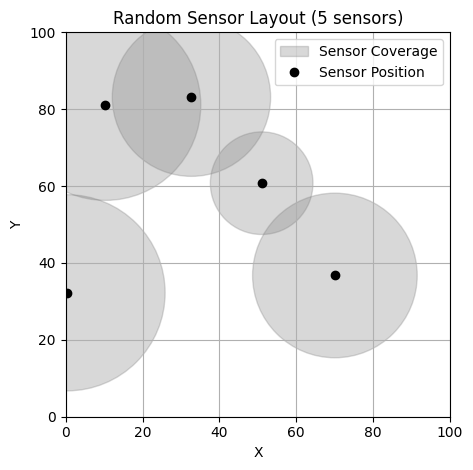

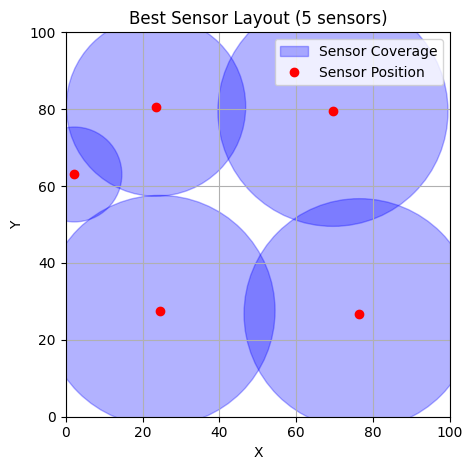

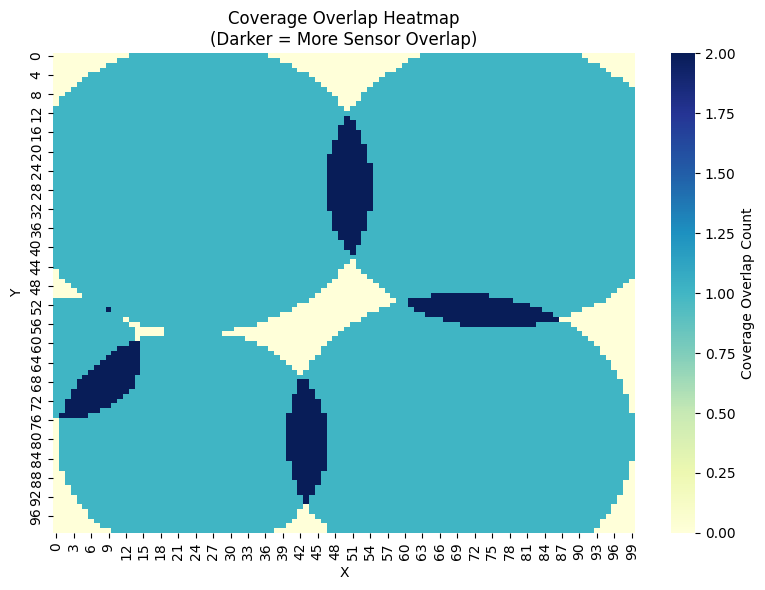

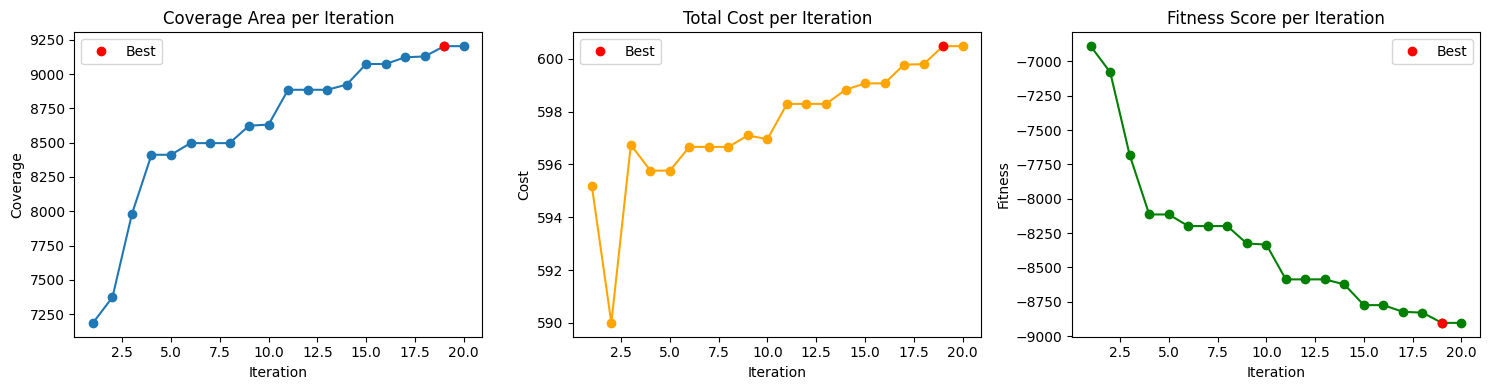

In [2]:
# hybrid_sensor_layout.py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

t0 = time.perf_counter()
# ================== 1. user input ==================
area_width  = int(input("Enter area width  (e.g. 100): "))
area_height = int(input("Enter area height (e.g. 100): "))
sensor_count = int(input("Enter number of sensors (e.g. 5): "))
r_min = float(input("Enter minimum radius (e.g. 5): "))
r_max = float(input("Enter maximum radius (e.g. 20): "))
fixed_cost  = float(input("Enter fixed part cost per sensor (e.g. 10): "))    # cost per sensor, regardless of radius

# ================== 2. cost parameters (NEW) ==================

COST_PER_RADIUS  = 0.8      # extra cost per unit of radius

# ================== 3. PSO parameters ==================
SWARM_SIZE   = 30
MAX_ITER     = 20
W_INERTIA    = 0.7          # inertia weight
C_COGNITIVE  = 1.5          # cognitive factor
C_SOCIAL     = 1.5          # social factor
V_MAX_FACTOR = 0.2          # max velocity = factor * (ub - lb)

# ================== 4. SA parameters ==================
SA_STEPS = 100
T0       = 1.0
ALPHA    = 0.95             # temperature decay

# ================== 5. grid preprocessing ==================
grid_res = 1
x_coords = np.arange(0, area_width , grid_res)
y_coords = np.arange(0, area_height, grid_res)
xx, yy   = np.meshgrid(x_coords, y_coords)
GRID     = np.c_[xx.ravel(), yy.ravel()]          # shape (n_pts, 2)

dim = sensor_count * 3                            # particle dimension

# ================== 6. fitness function ==================
def fitness(vec):
    """
    vec length = 3 * sensor_count
    format: [x1, y1, r1, x2, y2, r2, ...]
    """
    total_cov  = np.zeros(len(GRID), dtype=bool)
    heat       = np.zeros(len(GRID), dtype=int)
    total_cost = 0.0

    for i in range(sensor_count):
        x, y, r = vec[i*3:i*3+3]
        dist    = np.sqrt((GRID[:,0]-x)**2 + (GRID[:,1]-y)**2)
        covered = dist <= r
        total_cov |= covered
        heat     += covered.astype(int)
        # NEW cost model
        total_cost += fixed_cost + COST_PER_RADIUS * r

    coverage_score = np.sum(total_cov)            # number of covered grid points
    # multi-objective: maximise coverage, minimise cost
    return -coverage_score + 0.5 * total_cost, heat

# ================== 7. particle initialisation ==================
lb = np.tile([0,          0,          r_min], sensor_count)
ub = np.tile([area_width, area_height, r_max], sensor_count)
v_max = (ub - lb) * V_MAX_FACTOR

pos = np.random.uniform(lb, ub, (SWARM_SIZE, dim))
vel = np.random.uniform(-v_max, v_max, (SWARM_SIZE, dim))

pbest_pos = pos.copy()
pbest_val = np.full(SWARM_SIZE, np.inf)

gbest_pos  = None
gbest_val  = np.inf
gbest_heat = None

# ================== 8. history containers ==================
fitness_hist, coverage_hist, cost_hist = [], [], []
pos_hist = []

# ================== 9. main loop: PSO + SA ==================
for it in range(1, MAX_ITER + 1):
    # ---------- evaluate swarm ----------
    for i in range(SWARM_SIZE):
        f_val, heat = fitness(pos[i])

        if f_val < pbest_val[i]:              # update personal best
            pbest_val[i] = f_val
            pbest_pos[i] = pos[i].copy()

        if f_val < gbest_val:                 # update global best
            gbest_val  = f_val
            gbest_pos  = pos[i].copy()
            gbest_heat = heat.copy()

    # ---------- local search: SA around gbest ----------
    current, current_val, current_heat = gbest_pos.copy(), gbest_val, gbest_heat
    T = T0
    for _ in range(SA_STEPS):
        neighbor = current + np.random.normal(0, 0.1, dim) * (ub - lb)
        neighbor = np.clip(neighbor, lb, ub)
        n_val, n_heat = fitness(neighbor)
        delta = n_val - current_val
        if delta < 0 or np.random.rand() < np.exp(-delta / T):
            current, current_val, current_heat = neighbor, n_val, n_heat
        T *= ALPHA
    if current_val < gbest_val:               # accept SA improvement
        gbest_pos, gbest_val, gbest_heat = current, current_val, current_heat

    # ---------- PSO velocity / position update ----------
    r1, r2 = np.random.rand(SWARM_SIZE, dim), np.random.rand(SWARM_SIZE, dim)
    vel = (W_INERTIA * vel
           + C_COGNITIVE * r1 * (pbest_pos - pos)
           + C_SOCIAL    * r2 * (gbest_pos - pos))
    vel = np.clip(vel, -v_max, v_max)
    pos = np.clip(pos + vel, lb, ub)

    # ---------- history recording ----------
    total_cov  = np.zeros(len(GRID), dtype=bool)
    total_cost = 0.0
    for j in range(sensor_count):
        x, y, r = gbest_pos[j*3:j*3+3]
        dist = np.sqrt((GRID[:,0]-x)**2 + (GRID[:,1]-y)**2)
        total_cov |= dist <= r
        total_cost += fixed_cost + COST_PER_RADIUS * r
    coverage_hist.append(np.sum(total_cov))
    cost_hist.append(total_cost)
    fitness_hist.append(gbest_val)
    pos_hist.append(gbest_pos.copy())

    # ---------- verbose output ----------
    # if it == 1 or gbest_val == fitness_hist[-1]:
    #     print(f"New best at iteration {it}: {gbest_pos} {gbest_val}")
    if it == MAX_ITER:
        print(f"Best after iteration {it}: {gbest_pos} {gbest_val}")

print(f"Stopping search: maximum iterations reached --> {MAX_ITER}")

# ================== 10. final statistics ==================
final_cov  = np.zeros(len(GRID), dtype=bool)
final_cost = 0.0
for i in range(sensor_count):
    x, y, r = gbest_pos[i*3:i*3+3]
    dist = np.sqrt((GRID[:,0]-x)**2 + (GRID[:,1]-y)**2)
    final_cov |= dist <= r
    final_cost += fixed_cost + COST_PER_RADIUS * r

print(f"\n Final Coverage Area: {np.sum(final_cov)}")
print(f" Total Cost: {final_cost:.2f}")
print(f" Fitness Score: {gbest_val:.2f}")
hybrid_elapsed = time.perf_counter() - t0
print(f"⏱ Hybrid runtime: {hybrid_elapsed:.2f} s")

# ================== 11-bis. random baseline ==================
# 1. random layout (uniform in the same bounds)
rand_pos = np.zeros_like(gbest_pos)
for i in range(sensor_count):
    rand_pos[i*3]     = np.random.uniform(0, area_width)   # x
    rand_pos[i*3 + 1] = np.random.uniform(0, area_height)  # y
    rand_pos[i*3 + 2] = np.random.uniform(r_min, r_max)    # r

rand_val, rand_heat = fitness(rand_pos)
rand_cov  = np.zeros(len(GRID), dtype=bool)
rand_cost = 0.0
for i in range(sensor_count):
    x, y, r = rand_pos[i*3:i*3+3]
    dist = np.sqrt((GRID[:,0]-x)**2 + (GRID[:,1]-y)**2)
    rand_cov |= dist <= r
    rand_cost += fixed_cost  + COST_PER_RADIUS * r

print("\n--- RANDOM BASELINE ---")
print(f"Coverage Area: {np.sum(rand_cov)}")
print(f"Total Cost   : {rand_cost:.2f}")
print(f"Fitness      : {rand_val:.2f}")

# 2. plot random layout
fig, ax = plt.subplots()
ax.set_xlim(0, area_width)
ax.set_ylim(0, area_height)
ax.set_aspect('equal')
ax.set_title(f'Random Sensor Layout ({sensor_count} sensors)')
for i in range(sensor_count):
    x, y, r = rand_pos[i*3:i*3+3]
    ax.add_patch(plt.Circle((x, y), r, color='gray', alpha=0.3,
                            label='Sensor Coverage' if i == 0 else ""))
    ax.plot(x, y, 'ko', label='Sensor Position' if i == 0 else "")
handles, labels = ax.get_legend_handles_labels()
ax.legend(dict(zip(labels, handles)).values(),
          dict(zip(labels, handles)).keys())
plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()
plt.show()


# ================== 11. visualization: layout ==================
fig, ax = plt.subplots()
ax.set_xlim(0, area_width)
ax.set_ylim(0, area_height)
ax.set_aspect('equal')
ax.set_title(f'Best Sensor Layout ({sensor_count} sensors)')
for i in range(sensor_count):
    x, y, r = gbest_pos[i*3:i*3+3]
    ax.add_patch(plt.Circle((x, y), r, color='blue', alpha=0.3,
                            label='Sensor Coverage' if i == 0 else ""))
    ax.plot(x, y, 'ro', label='Sensor Position' if i == 0 else "")
handles, labels = ax.get_legend_handles_labels()
ax.legend(dict(zip(labels, handles)).values(),
          dict(zip(labels, handles)).keys())
plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()
plt.show()

# ================== 12. visualization: heatmap ==================
heatmap = gbest_heat.reshape(len(y_coords), len(x_coords))
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap, cmap='YlGnBu',
            cbar_kws={'label': 'Coverage Overlap Count'})
plt.title('Coverage Overlap Heatmap\n(Darker = More Sensor Overlap)')
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout()
plt.show()

# ================== 13. visualization: convergence curves ==================
best_iter = np.argmin(fitness_hist)
iters = np.arange(1, MAX_ITER + 1)

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.plot(iters, coverage_hist, 'o-')
plt.plot(iters[best_iter], coverage_hist[best_iter], 'ro', label='Best')
plt.title("Coverage Area per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Coverage")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(iters, cost_hist, 'o-', color='orange')
plt.plot(iters[best_iter], cost_hist[best_iter], 'ro', label='Best')
plt.title("Total Cost per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(iters, fitness_hist, 'o-', color='green')
plt.plot(iters[best_iter], fitness_hist[best_iter], 'ro', label='Best')
plt.title("Fitness Score per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.legend()

plt.tight_layout()
plt.show()

Enter area width (e.g. 100):  100
Enter area height (e.g. 100):  100
Enter number of sensors (e.g. 4):  4
Enter minimum radius (e.g. 5):  5
Enter maximum radius (e.g. 20):  20
Enter fixed part cost per sensor (e.g. 10):  10



⚙️ Start Optimization...
No constraints given.
New best for swarm at iteration 1: [27.66441716 57.73633574  5.         63.54750453 48.83388034 20.
 55.67091798 90.21555242 15.24598908 19.45223865 55.30341675 20.        ] -3096.9016043690663
Best after iteration 1: [27.66441716 57.73633574  5.         63.54750453 48.83388034 20.
 55.67091798 90.21555242 15.24598908 19.45223865 55.30341675 20.        ] -3096.9016043690663
Best after iteration 2: [27.66441716 57.73633574  5.         63.54750453 48.83388034 20.
 55.67091798 90.21555242 15.24598908 19.45223865 55.30341675 20.        ] -3096.9016043690663
New best for swarm at iteration 3: [22.33258358 39.35393105  5.         55.64605633 24.03978029 20.
 51.97123529 59.14038944 20.          7.84580989 26.31794334 16.75240742] -3183.299037033097
Best after iteration 3: [22.33258358 39.35393105  5.         55.64605633 24.03978029 20.
 51.97123529 59.14038944 20.          7.84580989 26.31794334 16.75240742] -3183.299037033097
New best for swar

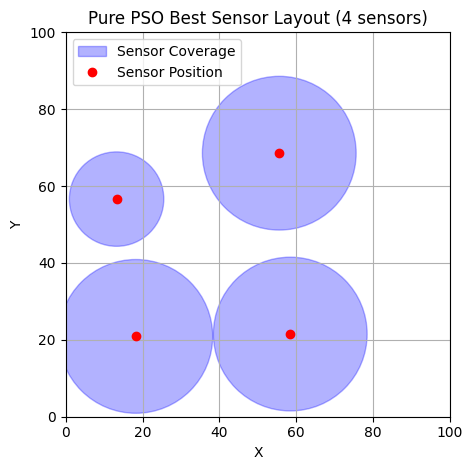

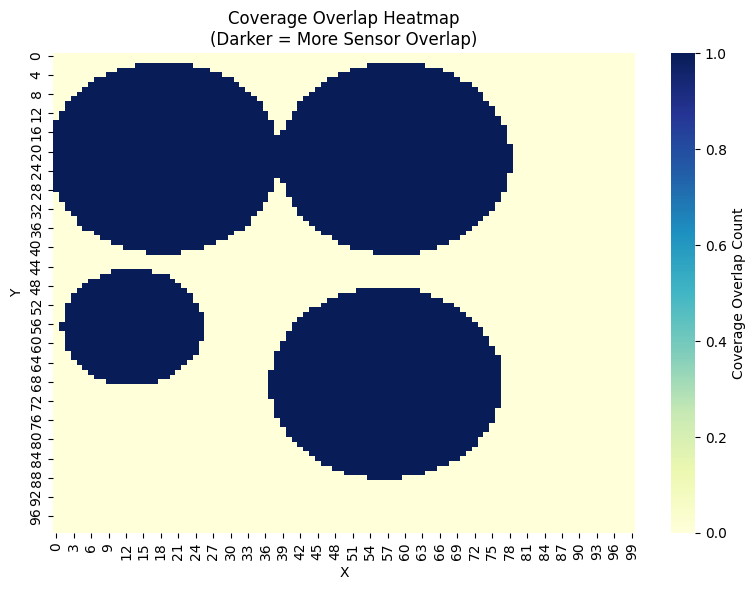


--- Final Optimization Result ---
Best Fitness (F1/F2)   : 4948000000.0206
Total Cost (F1)        : 104.00
Covered Points (F2)    : 5052
Runtime (seconds)      : 0.47


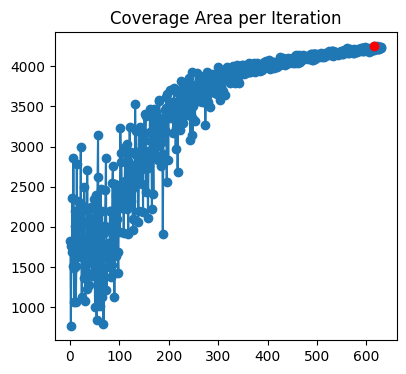

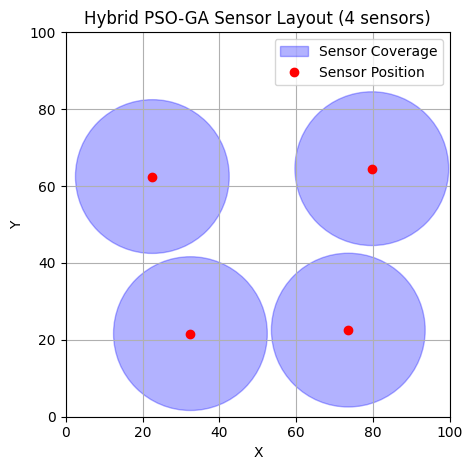

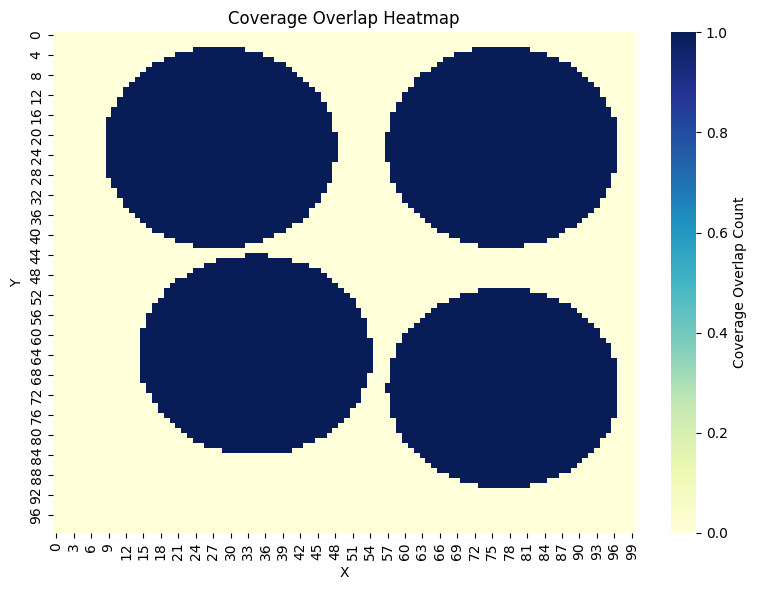

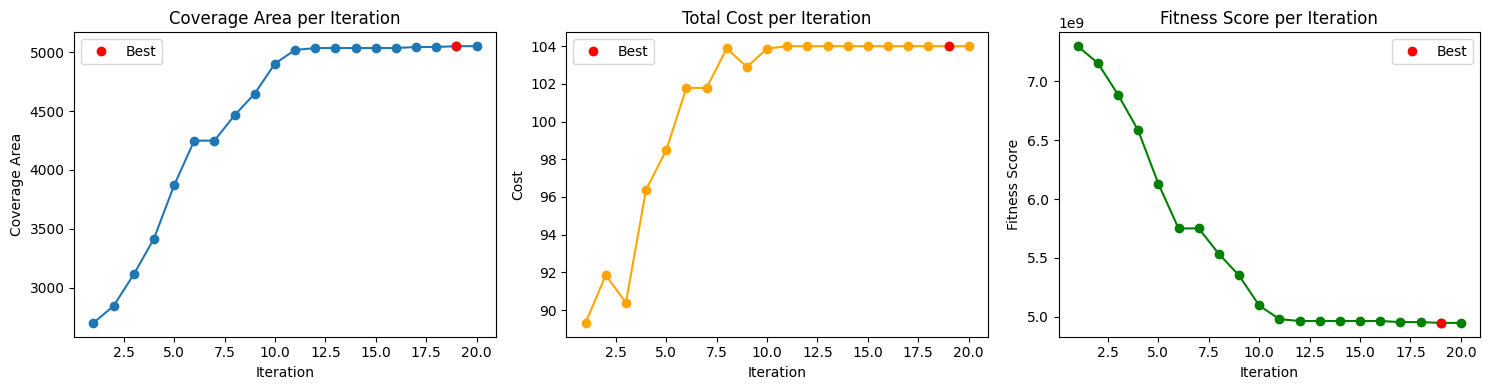

ModuleNotFoundError: No module named 'ace_tools'

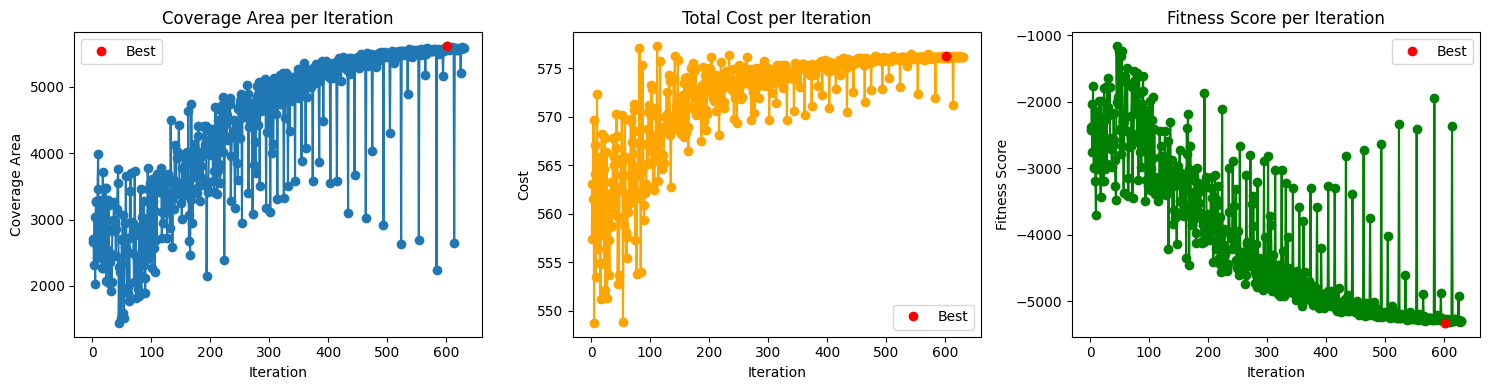

In [3]:
#纯pso 作为对比方案
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyswarm import pso
import time


t0 = time.perf_counter()

# ---------------- 1. user input ----------------
area_width   = int(input("Enter area width (e.g. 100): "))
area_height  = int(input("Enter area height (e.g. 100): "))
sensor_count = int(input("Enter number of sensors (e.g. 4): "))
r_min        = float(input("Enter minimum radius (e.g. 5): "))
r_max        = float(input("Enter maximum radius (e.g. 20): "))

# >>> cost parameters (match Hybrid version) <<<
fixed_cost        = float(input("Enter fixed part cost per sensor (e.g. 10): "))
COST_PER_RADIUS   = 0.8          # extra cost per unit radius  #### <<< changed >>> 

radius_bounds = (r_min, r_max)
grid_resolution = 1

x_coords = np.arange(0, area_width , grid_resolution)
y_coords = np.arange(0, area_height, grid_resolution)
xx, yy   = np.meshgrid(x_coords, y_coords)
grid_points = np.c_[xx.ravel(), yy.ravel()]

fitness_history = []
coverage_history = []
cost_history     = []
position_history = []

# ---------------- 2. fitness function ----------------
def fitness_function(particle):
    global last_heatmap
    total_covered = np.zeros(len(grid_points), dtype=bool)
    heat          = np.zeros(len(grid_points), dtype=int)
    total_cost    = 0.0

    for i in range(sensor_count):
        x = particle[i*3]
        y = particle[i*3 + 1]
        r = particle[i*3 + 2]

        dist = np.sqrt((grid_points[:, 0] - x) ** 2 +
                       (grid_points[:, 1] - y) ** 2)
        covered = dist <= r
        total_covered |= covered
        heat         += covered.astype(int)

        # ------ cost model aligned with Hybrid code ------
        total_cost += fixed_cost + COST_PER_RADIUS * r      #### <<< changed >>>

    coverage_score = np.sum(total_covered)
    fitness = -coverage_score + 0.5 * total_cost            #### <<< changed >>>

    # history
    fitness_history.append(fitness)
    coverage_history.append(coverage_score)
    cost_history.append(total_cost)
    position_history.append(particle.copy())
    last_heatmap = heat
    return fitness

# ---------------- 3. PSO bounds ----------------
lb, ub = [], []
for _ in range(sensor_count):
    lb.extend([0, 0, radius_bounds[0]])
    ub.extend([area_width, area_height, radius_bounds[1]])

# ---------------- 4. run PSO ----------------
print("\n⚙️ Start Optimization...")
best_position, best_score = pso(
    fitness_function,
    lb=lb,
    ub=ub,
    swarmsize=30,
    maxiter=20,
    debug=True
)
print("✅ Optimization Complete")

# ---------------- 5. trace best history ----------------
for i in range(len(fitness_history)):
    if i == 0 or fitness_history[i] < min(fitness_history[:i]):
        print(f"New best for swarm at iteration {i+1}: {position_history[i]} {fitness_history[i]}")
    if i == len(fitness_history) - 1:
        print(f"Best after iteration {i+1}: {position_history[i]} {fitness_history[i]}")
print("Stopping search: maximum iterations reached --> 20")

# ---------------- 6. summary ----------------
total_covered = np.zeros(len(grid_points), dtype=bool)
total_cost = 0.0
for i in range(sensor_count):
    x = best_position[i*3]
    y = best_position[i*3 + 1]
    r = best_position[i*3 + 2]
    dist = np.sqrt((grid_points[:, 0] - x) ** 2 + (grid_points[:, 1] - y) ** 2)
    total_covered |= dist <= r
    total_cost += fixed_cost + COST_PER_RADIUS * r          #### <<< changed >>>

print(f"\n📊 Final Coverage Area: {np.sum(total_covered)}")
print(f"💰 Total Cost: {total_cost:.2f}")
print(f"🎯 Fitness Score: {best_score:.2f}")
pure_elapsed = time.perf_counter() - t0
print(f"⏱ Pure PSO runtime: {pure_elapsed:.2f} s")

# ---------------- 7. layout plot ----------------
fig, ax = plt.subplots()
ax.set_xlim(0, area_width)
ax.set_ylim(0, area_height)
ax.set_aspect('equal')
ax.set_title(f'Pure PSO Best Sensor Layout ({sensor_count} sensors)')
for i in range(sensor_count):
    x = best_position[i*3]
    y = best_position[i*3 + 1]
    r = best_position[i*3 + 2]
    ax.add_patch(plt.Circle((x, y), r, color='blue', alpha=0.3,
                            label='Sensor Coverage' if i == 0 else ""))
    ax.plot(x, y, 'ro', label='Sensor Position' if i == 0 else "")
handles, labels = ax.get_legend_handles_labels()
ax.legend(dict(zip(labels, handles)).values(),
          dict(zip(labels, handles)).keys())
plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()
plt.show()

# ---------------- 8. heatmap ----------------
heatmap = last_heatmap.reshape((len(y_coords), len(x_coords)))
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap, cmap='YlGnBu',
            cbar_kws={'label': 'Coverage Overlap Count'})
plt.title('Coverage Overlap Heatmap\n(Darker = More Sensor Overlap)')
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout()
plt.show()

# ---------------- 9. convergence curves ----------------
best_iter = np.argmin(fitness_history)
iterations = list(range(1, len(fitness_history) + 1))

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.plot(iterations, coverage_history, 'o-')
plt.plot(iterations[best_iter], coverage_history[best_iter], 'ro', label='Best')
plt.title("Coverage Area per Iteration")
import matplotlib.pyplot as plt
import seaborn as sns
import time

# ---------------- 1. Configuration (replace with input() in user environments) ----------------
params = {
    "area_width": 100,
    "area_height": 100,
    "sensor_count": 4,
    "r_min": 5,
    "r_max": 20,
    "fixed_cost": 10,
    "cost_per_radius": 0.8,
    "min_coverage_per_point": 1,
    "grid_resolution": 1,
    "swarm_size": 30,
    "max_iter": 20,
    "ga_generations": 10,
    "mutation_rate": 0.2
}

# ---------------- 2. Grid Setup ----------------
x_coords = np.arange(0, params["area_width"], params["grid_resolution"])
y_coords = np.arange(0, params["area_height"], params["grid_resolution"])
xx, yy = np.meshgrid(x_coords, y_coords)
GRID = np.c_[xx.ravel(), yy.ravel()]
dim = params["sensor_count"] * 3
lb = np.tile([0, 0, params["r_min"]], params["sensor_count"])
ub = np.tile([params["area_width"], params["area_height"], params["r_max"]], params["sensor_count"])
EPS = 1e-6
PENALTY = 1e6

fitness_history = []
coverage_history = []
cost_history = []
position_history = []

# ---------------- 3. Fitness Function based on Equation (4) ----------------
def fitness(x):
    global last_heatmap
    coverage = np.zeros(len(GRID), dtype=int)
    cost = 0.0

    for i in range(params["sensor_count"]):
        x_s, y_s, r = x[i*3:i*3+3]
        dist = np.hypot(GRID[:, 0] - x_s, GRID[:, 1] - y_s)
        cover_mask = dist <= r
        coverage += cover_mask.astype(int)
        cost += params["fixed_cost"] + params["cost_per_radius"] * r

    uncovered = np.sum(coverage < params["min_coverage_per_point"])
    F1 = cost
    F2 = np.sum(coverage >= params["min_coverage_per_point"])
    last_heatmap = coverage
    if F2 == 0:
        return float("inf"), F1, F2
    penalty = PENALTY * uncovered
    return F1 / (F2 + EPS) + penalty, F1, F2

# ---------------- 4. PSO + GA ----------------
V_MAX_FACTOR = 0.2
W_INERTIA = 0.7
C1 = 1.5
C2 = 1.5

np.random.seed(42)
pos = np.random.uniform(lb, ub, (params["swarm_size"], dim))
vel = np.random.uniform(-1, 1, (params["swarm_size"], dim)) * (ub - lb) * V_MAX_FACTOR
pbest_pos = pos.copy()
pbest_val = np.full(params["swarm_size"], np.inf)
gbest_val = np.inf
gbest_pos = None

start_time = time.perf_counter()

for t in range(params["max_iter"]):
    for i in range(params["swarm_size"]):
        f, f1, f2 = fitness(pos[i])
        if f < pbest_val[i]:
            pbest_val[i] = f
            pbest_pos[i] = pos[i].copy()
        if f < gbest_val:
            gbest_val = f
            gbest_pos = pos[i].copy()
            best_cost = f1
            best_coverage = f2

    fitness_history.append(gbest_val)
    cost_history.append(best_cost)
    coverage_history.append(best_coverage)
    position_history.append(gbest_pos.copy())

    # --- GA Search
    for _ in range(params["ga_generations"]):
        children = []
        for _ in range(3):
            idx = np.random.choice(len(pbest_pos), 2, replace=False)
            p1, p2 = pbest_pos[idx[0]], pbest_pos[idx[1]]
            cross = np.where(np.random.rand(dim) < 0.5, p1, p2)
            if np.random.rand() < params["mutation_rate"]:
                mi = np.random.randint(0, dim)
                cross[mi] += np.random.normal(0, 0.1 * (ub[mi] - lb[mi]))
            cross = np.clip(cross, lb, ub)
            children.append(cross)
        for child in children:
            f, f1, f2 = fitness(child)
            if f < gbest_val:
                gbest_val = f
                gbest_pos = child.copy()
                best_cost = f1
                best_coverage = f2

    # --- PSO Update
    r1, r2 = np.random.rand(params["swarm_size"], dim), np.random.rand(params["swarm_size"], dim)
    vel = (W_INERTIA * vel +
           C1 * r1 * (pbest_pos - pos) +
           C2 * r2 * (gbest_pos - pos))
    vel = np.clip(vel, -V_MAX_FACTOR * (ub - lb), V_MAX_FACTOR * (ub - lb))
    pos = np.clip(pos + vel, lb, ub)

runtime = time.perf_counter() - start_time

# ---------------- 5. Summary Output ----------------
print("\n--- Final Optimization Result ---")
print(f"Best Fitness (F1/F2)   : {gbest_val:.4f}")
print(f"Total Cost (F1)        : {best_cost:.2f}")
print(f"Covered Points (F2)    : {best_coverage}")
print(f"Runtime (seconds)      : {runtime:.2f}")

# ---------------- 6. Layout Plot ----------------
fig, ax = plt.subplots()
ax.set_xlim(0, params["area_width"])
ax.set_ylim(0, params["area_height"])
ax.set_aspect('equal')
ax.set_title(f'Hybrid PSO-GA Sensor Layout ({params["sensor_count"]} sensors)')
for i in range(params["sensor_count"]):
    x, y, r = gbest_pos[i*3], gbest_pos[i*3+1], gbest_pos[i*3+2]
    ax.add_patch(plt.Circle((x, y), r, color='blue', alpha=0.3, label='Sensor Coverage' if i == 0 else ""))
    ax.plot(x, y, 'ro', label='Sensor Position' if i == 0 else "")
handles, labels = ax.get_legend_handles_labels()
ax.legend(dict(zip(labels, handles)).values(), dict(zip(labels, handles)).keys())
plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()
plt.show()

# ---------------- 7. Heatmap ----------------
heatmap = last_heatmap.reshape((len(y_coords), len(x_coords)))
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap, cmap='YlGnBu', cbar_kws={'label': 'Coverage Overlap Count'})
plt.title('Coverage Overlap Heatmap')
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout()
plt.show()

# ---------------- 8. Convergence Plots ----------------
best_iter = np.argmin(fitness_history)
iterations = list(range(1, len(fitness_history) + 1))

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(iterations, coverage_history, 'o-')
plt.plot(iterations[best_iter], coverage_history[best_iter], 'ro', label='Best')
plt.title("Coverage Area per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Coverage Area")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(iterations, cost_history, 'o-', color='orange')
plt.plot(iterations[best_iter], cost_history[best_iter], 'ro', label='Best')
plt.title("Total Cost per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(iterations, fitness_history, 'o-', color='green')
plt.plot(iterations[best_iter], fitness_history[best_iter], 'ro', label='Best')
plt.title("Fitness Score per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Fitness Score")
plt.legend()

plt.tight_layout()
plt.show()


                        # ---------------- 9. Print Sensor Details ----------------
import pandas as pd

sensor_details = {
    "Sensor #": [],
    "X": [],
    "Y": [],
    "Radius": [],
    "Cost": []
}

for i in range(params["sensor_count"]):
    x = gbest_pos[i*3]
    y = gbest_pos[i*3 + 1]
    r = gbest_pos[i*3 + 2]
    cost = params["fixed_cost"] + params["cost_per_radius"] * r
    sensor_details["Sensor #"].append(i+1)
    sensor_details["X"].append(round(x, 2))
    sensor_details["Y"].append(round(y, 2))
    sensor_details["Radius"].append(round(r, 2))
    sensor_details["Cost"].append(round(cost, 2))

df = pd.DataFrame(sensor_details)
import ace_tools as tools; tools.display_dataframe_to_user(name="Sensor Placement Results", dataframe=df)
